# Clustering in Latent Space for Multiclass Data

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [2]:
from pyldl.activations import Sigmoid, Tanh
from pyldl.encapsulations import AutoEncoder, Sequential
from pyldl.losses import BCELoss, MSELoss
from pyldl.modules import Linear
from pyldl.optimizers import SGD
from pyldl.utils import encode_one_hot, kullback_leibler_divergence, load_usps

In [3]:
from itertools import product
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits, fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

## Loading the Dataset

In [4]:
np.random.seed(0)

In [5]:
digits = load_digits()

X = digits.data
y = digits.target

# faces = fetch_olivetti_faces()
# X = faces.data
# y = faces.target

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_train, X_test = train_test_split(X, test_size=0.2)

## Autoencoder and Reconstruction

In [6]:
encoder = Sequential(
    Linear(X_train.shape[1], 32),
    Tanh(),
    Linear(32, 16),
    Tanh(),
    Linear(16, 2),
    Tanh()
)

decoder = Sequential(
    Linear(2, 16),
    Tanh(),
    Linear(16, 32),
    Tanh(),
    Linear(32, X_train.shape[1]),
    Tanh()
)

autoencoder = AutoEncoder(encoder, decoder)

In [7]:
losses = SGD(autoencoder, MSELoss(), X_train, X_train, batch_size=32, gradient_step=1e-3, n_iter=1000)

100%|██████████| 1000/1000 [00:11<00:00, 87.94it/s]


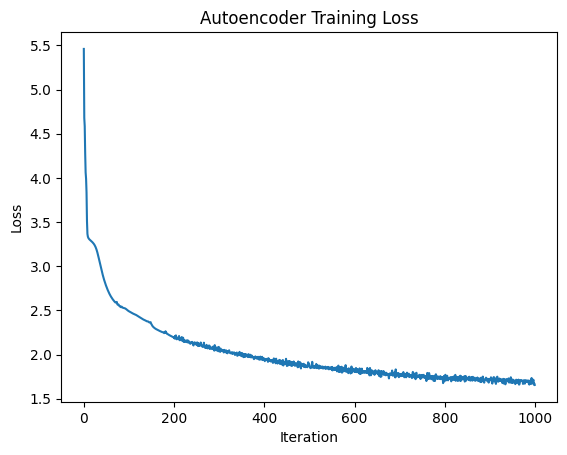

In [8]:
plt.plot(losses)
plt.title("Autoencoder Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [9]:
yhat = autoencoder(X_test)
print("Score: ", kullback_leibler_divergence(yhat, X_test))

Score:  36.550876074995045


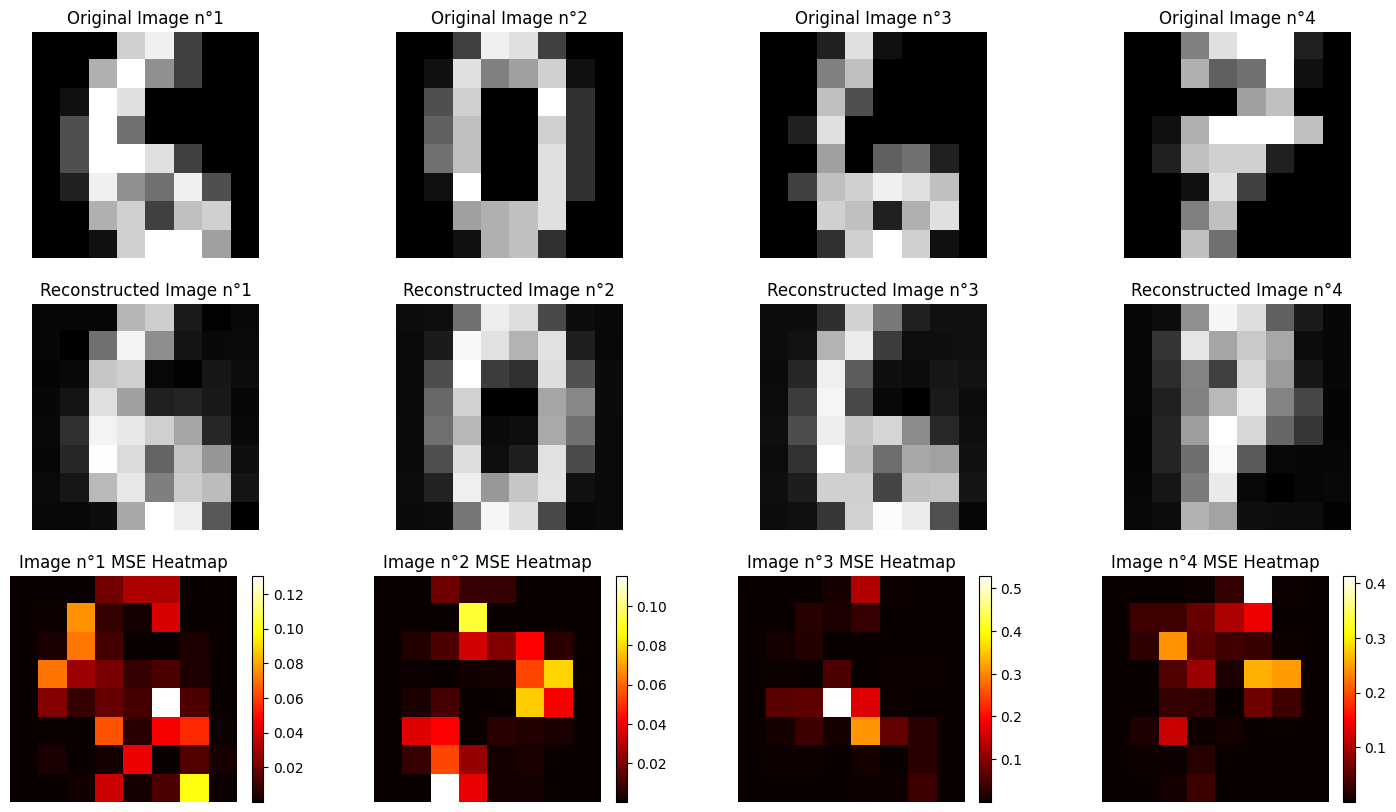

In [22]:
n_images = 4

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = X_test[random_indexes]
reconstructed_images = autoencoder(original_images)

plt.subplots(3, 4, figsize=(18, 10))
for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.title(f"Original Image n°{i+1}")
    plt.imshow(original_images[i].reshape(8,8), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 4, i+5)
    plt.title(f"Reconstructed Image n°{i+1}")
    plt.imshow(reconstructed_images[i].reshape(8,8), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 4, i+9)
    mse_images = (original_images[i] - reconstructed_images[i])**2
    heatmap_data = mse_images.reshape(8,8)
    heatmap = plt.imshow(heatmap_data, cmap='hot')
    plt.colorbar(heatmap)
    plt.title(f'Image n°{i+1} MSE Heatmap')
    plt.axis('off')

## Network Optimization

In [11]:
# params = {
#     "activation_functions": [Sigmoid, Tanh],
#     "batch_size": [32, 64, 128],
#     "gradient_step": [0.01, 0.001, 0.0001],
#     "loss": [BCELoss, MSELoss],
#     "n_epochs": [500, 1000, 2000],
#     "n_neurons_per_layer": [[X_train.shape[1], 32], [X_train.shape[1], 32, 16], [X_train.shape[1], 32, 16, 8]],
# }

params = {
    "activation_functions": [Tanh],
    "batch_size": [32],
    "gradient_step": [0.001],
    "loss": [MSELoss],
    "n_epochs": [1000],
    "n_neurons_per_layer": [[X_train.shape[1], 32, 16, 2]],
}

In [12]:
def grid_search(X_train, X_test, params):
    best_score = np.inf
    best_model = None
    best_params = None
    best_losses = None
    for activation, batch_size, gradient_step, loss, n_epochs, n_neurons_per_layer in product(*params.values()):
        encoder_layers, decoder_layers = [], []
        for i in range(len(n_neurons_per_layer)-1):
            encoder_layers += [Linear(n_neurons_per_layer[i], n_neurons_per_layer[i+1]), activation()]
            decoder_layers = [Linear(n_neurons_per_layer[i+1], n_neurons_per_layer[i]), activation()] + decoder_layers
        autoencoder = AutoEncoder(Sequential(*encoder_layers), Sequential(*decoder_layers))
        losses = SGD(autoencoder, loss(), X_train, X_train, batch_size=batch_size, gradient_step=gradient_step, n_iter=n_epochs)
        reconstructed_images = autoencoder(X_test)
        score = np.abs(kullback_leibler_divergence(X_test, reconstructed_images))
        if score < best_score:
            best_model = autoencoder
            best_score = score
            best_losses = losses
            best_params = {
                "activation_functions": activation.__class__.__name__,
                "batch_size": batch_size,
                "gradient_step": gradient_step,
                "loss": loss.__class__.__name__,
                "n_epochs": n_epochs,
                "n_neurons_per_layer": n_neurons_per_layer,
            }
    return best_model, best_params, best_score, best_losses

In [13]:
best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, params)

100%|██████████| 1000/1000 [00:12<00:00, 82.13it/s]


In [14]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'ABCMeta', 'batch_size': 32, 'gradient_step': 0.001, 'loss': 'ABCMeta', 'n_epochs': 1000, 'n_neurons_per_layer': [64, 32, 16, 2]}


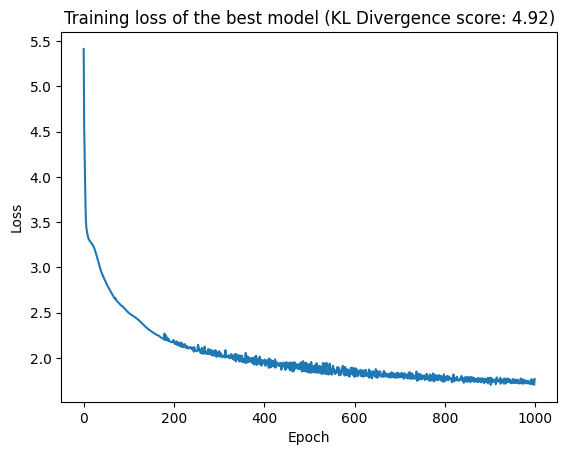

In [15]:
plt.plot(best_losses)
plt.title(f"Training loss of the best model (KL Divergence score: {best_score:.2f})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

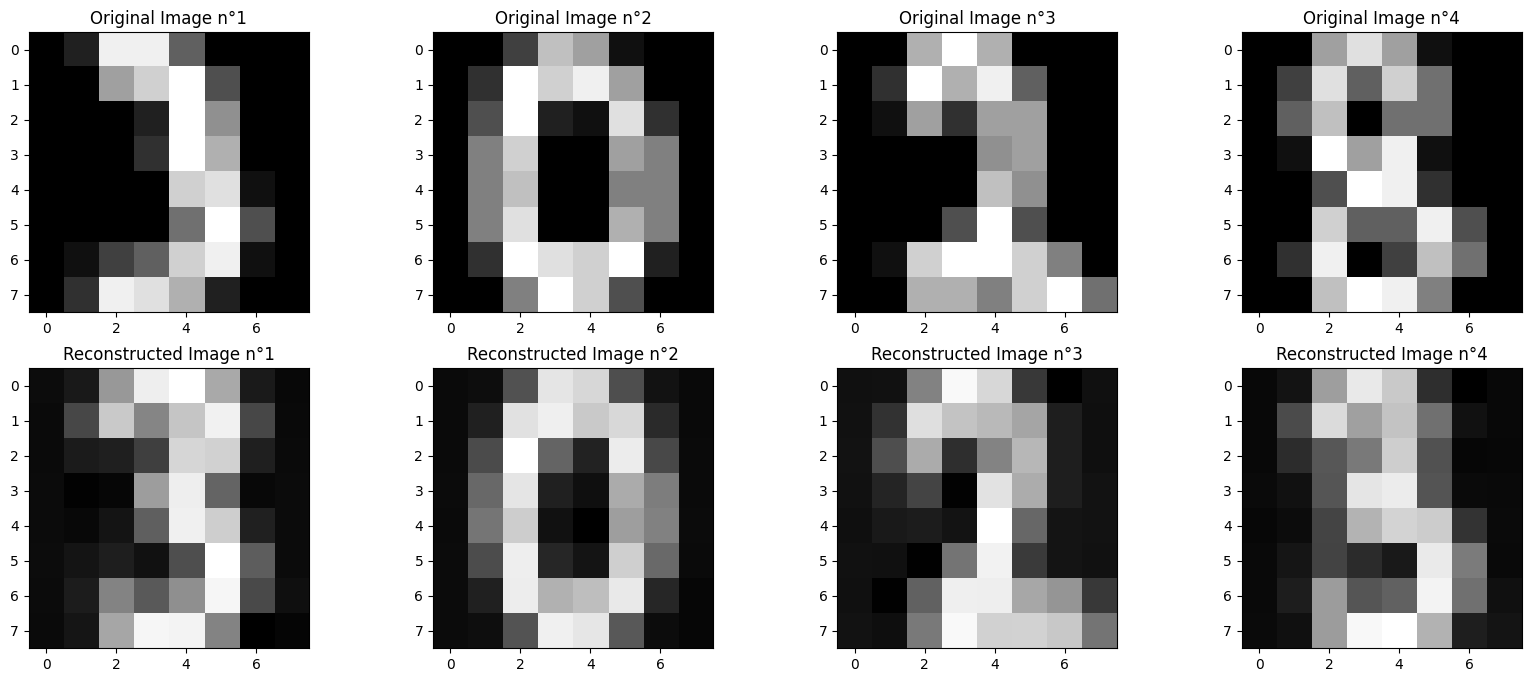

In [16]:
n_images = 8
subplots_size = n_images//2

random_indexes = np.random.choice(range(X_test.shape[0]), subplots_size, replace=False)
original_images = X_test[random_indexes]
reconstructed_images = best_model(original_images)

plt.subplots(2, 4, figsize=(20, 8))
for i in range(subplots_size):
    plt.subplot(2, 4, i+1)
    plt.title(f"Original Image n°{i+1}")
    plt.imshow(original_images[i].reshape(8,8), cmap='gray')
    plt.subplot(2, 4, subplots_size+i+1)
    plt.title(f"Reconstructed Image n°{i+1}")
    plt.imshow(reconstructed_images[i].reshape(8,8), cmap='gray')

## Clustering

In [17]:
def cluster_latent_representation(autoencoder, X, n_classes=10):
    latent_representation = autoencoder._encoder(X)
    kmeans = KMeans(n_clusters=n_classes)
    labels = kmeans.fit_predict(latent_representation)
    return labels

def contingency_matrix(y_true, y_pred):
    contingency_matrix = np.zeros((len(np.unique(y_true)), len(np.unique(y_pred))))
    for i in range(len(y_true)):
        contingency_matrix[y_true[i], y_pred[i]] += 1
    return contingency_matrix

def clusters_majority_class(y_true, y_pred):
    m = contingency_matrix(y_true, y_pred)
    clusters_and_classes = {i: np.argmax(m[:,i]) for i in range(m.shape[1])}
    return clusters_and_classes

def clustering_accuracy(y_true, y_pred):
    clusters_and_classes = clusters_majority_class(y_true, y_pred)
    y_pred = np.array([clusters_and_classes[i] for i in y_pred])
    return np.mean(y_true == y_pred)

def clusters_purity(y_true, y_pred):
    m = contingency_matrix(y_true, y_pred)
    return np.max(m, axis=0) / np.sum(m, axis=0)

In [18]:
labels = cluster_latent_representation(best_model, X)
accuracy = clustering_accuracy(y, labels)
clusters_classes = clusters_majority_class(y, labels)
clusters_purities = clusters_purity(y, labels)

print(f"Clustering Accuracy: {accuracy*100:.2f}%")
print(f"Majority class of each cluster: {clusters_classes}")
print(f"Purity of each cluster: {clusters_purities}")

Clustering Accuracy: 67.11%
Majority class of each cluster: {0: 7, 1: 6, 2: 5, 3: 4, 4: 2, 5: 0, 6: 3, 7: 1, 8: 5, 9: 7}
Purity of each cluster: [0.96644295 0.63829787 0.56410256 0.72139303 0.98657718 0.58223684
 0.70614035 0.63076923 0.50241546 0.38961039]


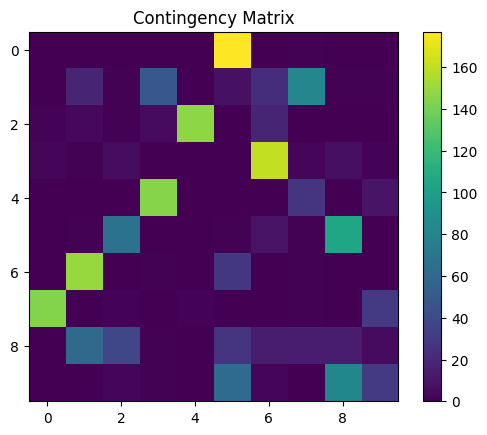

In [23]:
m = contingency_matrix(y, labels)

fig = plt.figure()
mat_plot = plt.imshow(m)
plt.title("Contingency Matrix")
plt.colorbar(mat_plot)

plt.show()

## Optimization and clustering on another Dataset

In [25]:
X, y = load_usps("../data/USPS_data.txt")

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
params = {
    "activation_functions": [Tanh],
    "batch_size": [32],
    "gradient_step": [0.001],
    "loss": [MSELoss],
    "n_epochs": [1000],
    "n_neurons_per_layer": [[X_train.shape[1], 128, 64, 32]],
}

In [27]:
best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, params)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:51<00:00,  2.84it/s]


In [28]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'ABCMeta', 'batch_size': 32, 'gradient_step': 0.001, 'loss': 'ABCMeta', 'n_epochs': 1000, 'n_neurons_per_layer': [256, 128, 64, 32]}


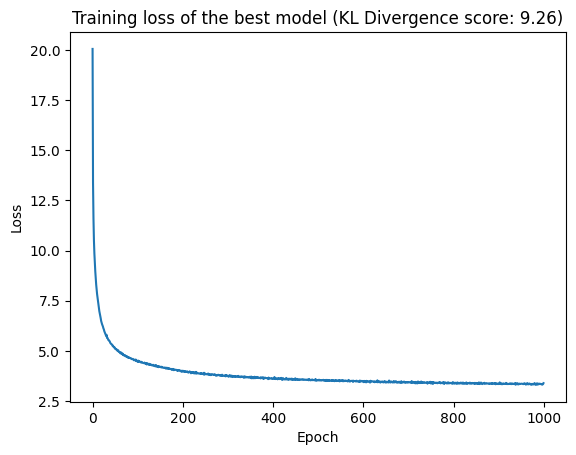

In [30]:
plt.plot(best_losses)
plt.title(f"Training loss of the best model (KL Divergence score: {best_score:.2f})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

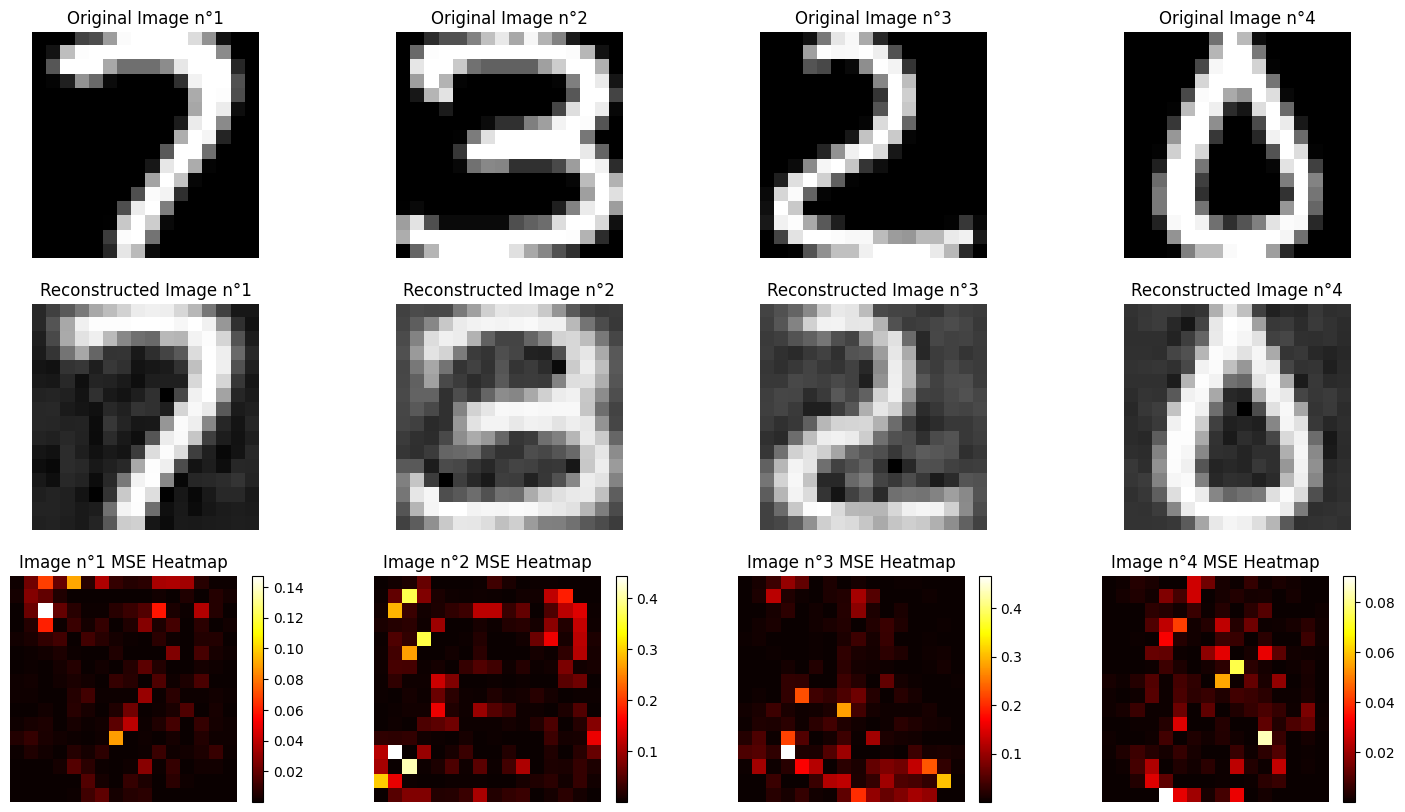

In [31]:
n_images = 8
subplots_size = n_images//2

random_indexes = np.random.choice(range(X_test.shape[0]), subplots_size, replace=False)
original_images = X_test[random_indexes]
reconstructed_images = best_model(original_images)

plt.subplots(3, 4, figsize=(18, 10))
for i in range(subplots_size):
    plt.subplot(3, 4, i+1)
    plt.title(f"Original Image n°{i+1}")
    plt.imshow(original_images[i].reshape(16,16), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 4, i+5)
    plt.title(f"Reconstructed Image n°{i+1}")
    plt.imshow(reconstructed_images[i].reshape(16,16), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 4, i+9)
    mse_images = (original_images[i] - reconstructed_images[i])**2
    heatmap_data = mse_images.reshape(16,16)
    heatmap = plt.imshow(heatmap_data, cmap='hot')
    plt.colorbar(heatmap)
    plt.title(f'Image n°{i+1} MSE Heatmap')
    plt.axis('off')

In [32]:
labels = cluster_latent_representation(best_model, X)
accuracy = clustering_accuracy(y, labels)
clusters_classes = clusters_majority_class(y, labels)
clusters_purities = clusters_purity(y, labels)

print(f"Clustering Accuracy: {accuracy*100:.2f}%")
print(f"Majority class of each cluster: {clusters_classes}")
print(f"Purity of each cluster: {clusters_purities}")

Clustering Accuracy: 72.65%
Majority class of each cluster: {0: 6, 1: 7, 2: 1, 3: 0, 4: 5, 5: 3, 6: 8, 7: 2, 8: 0, 9: 4}
Purity of each cluster: [0.78787879 0.45773732 0.98569157 0.90671642 0.44301994 0.66342142
 0.69413233 0.86347725 0.91523179 0.62178828]


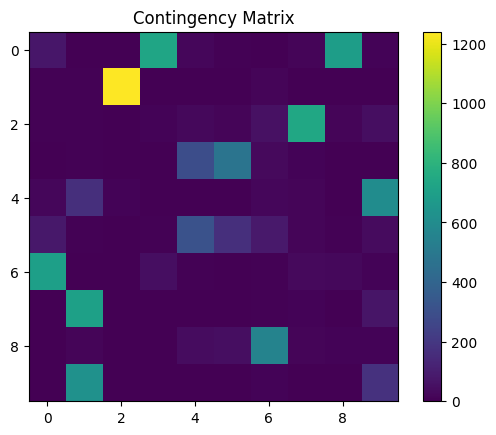

In [33]:
m = contingency_matrix(y, labels)

fig = plt.figure()
mat_plot = plt.imshow(m)
plt.title("Contingency Matrix")
plt.colorbar(mat_plot)

plt.show()